# Librerías

In [1]:
# Para la importación de los datos desde Socrata
from sodapy  import Socrata

from datetime   import datetime
import pandas   as pd
import numpy    as np
import warnings
import scipy.stats as stats
import math

#Para gráficos y mapas de calor
import seaborn            as sb
import matplotlib.pyplot  as plt
import plotly.graph_objs  as go

#Para la imputación de los datos
from sklearn.impute     import SimpleImputer
from sklearn.compose    import ColumnTransformer
import missingno        as msno

#Para el pre-procesamiento de los datos
from sklearn.preprocessing      import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection  import SelectKBest, chi2

# Suprimir los warnings específicos
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Lectura


In [2]:
#inicio = datetime.now()
#print(f"Hora inicial: {inicio.strftime('%Y-%m-%d %H:%M:%S')}")

#client = Socrata("www.datos.gov.co", None, timeout=60)
#DATASET = "kgxf-xxbe"

#limit = 50_000
#offset = 0
#frames = []

#while True:
#    results = client.get(DATASET, limit=limit, offset=offset)
#    if not results:
#        break
#    frames.append(pd.DataFrame.from_records(results))
#    offset += limit

#saber11_df = pd.concat(frames, ignore_index=True)

# ----------------------------------------
#fin = datetime.now()
#print(f"Hora final:   {fin.strftime('%Y-%m-%d %H:%M:%S')}")
#print(f"Duración total: {fin - inicio}")
#print(f"Filas descargadas: {saber11_df.shape[0]:,}")
# ----------------------------------------


El conjunto de datos corresponde a los Resultados únicos de la prueba Saber 11, publicados por el ICFES y disponibles en el portal Datos Abiertos de Colombia.
Contiene información detallada sobre los estudiantes que presentaron la prueba, las características del colegio y variables familiares y socioeconómicas asociadas al desempeño académico.


La versión empleada fue obtenida mediante la API pública de Socrata, lo que permitió descargar el total de registros (7.109.704 observaciones)

En caso de que la información extraida por la API no este disponible , disponemos de la siguiente celda para poder cargar los datos directamente de un archivo ".parquet".

- para poder hacer uso de esta alternativa debemos descomentar la linea de codigo y ejecutar la celda 

In [2]:
saber11_df = pd.read_parquet("saber11_completo.parquet")
saber11_df.shape[0]

7109704

Para poder identificar el tipo de dato de las columnas y si tienen alguna novedad que debamos tener en cuenta para tratar los datos correctamente  utilizaremos el comando ".info()" para ver el tipo de dato de cada campo .

- Encontramos que todos los datos cargados del dataframe son de tipo "object" 
- Por lo que mas adelante se tendra que modificar el tipo de dato en algunos campos para poder tratarlos correctamente

In [3]:
saber11_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109704 entries, 0 to 7109703
Data columns (total 51 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   periodo                        object
 1   estu_tipodocumento             object
 2   estu_consecutivo               object
 3   cole_area_ubicacion            object
 4   cole_bilingue                  object
 5   cole_calendario                object
 6   cole_caracter                  object
 7   cole_cod_dane_establecimiento  object
 8   cole_cod_dane_sede             object
 9   cole_cod_depto_ubicacion       object
 10  cole_cod_mcpio_ubicacion       object
 11  cole_codigo_icfes              object
 12  cole_depto_ubicacion           object
 13  cole_genero                    object
 14  cole_jornada                   object
 15  cole_mcpio_ubicacion           object
 16  cole_naturaleza                object
 17  cole_nombre_establecimiento    object
 18  cole_nombre_sede      

El dataset cuenta con 51 columnas, que abarcan:

Identificación y datos personales del estudiante: tipo de documento, género, fecha de nacimiento, departamento y municipio de residencia.
Información del establecimiento educativo: nombre, código DANE, ubicación geográfica, calendario, carácter, jornada y naturaleza del colegio.

Contexto familiar: nivel educativo de los padres, número de personas en el hogar y acceso a bienes como computador, internet o lavadora.

Resultados académicos: puntajes por área (lectura crítica, matemáticas, ciencias naturales, sociales e inglés) y el puntaje global.

In [4]:
saber11_df.head(4)

,periodo,estu_tipodocumento,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
0,20131,CR,SB11201310000414,URBANO,N,B,ACADÉMICO,311848000812,311848000812,11,11001,022574,BOGOTA,FEMENINO,COMPLETA,BOGOTÁ D.C.,NO OFICIAL,GIMN FEMENINO,GIMN FEMENINO,S,11,11001,11,11001,BOGOTÁ,BOGOTÁ,PUBLICAR,ESTUDIANTE,08/08/1994,F,BOGOTÁ D.C.,BOGOTÁ D.C.,COLOMBIA,COLOMBIA,N,Cuatro,Educación profesional completa,Educación profesional completa,Estrato 6,Cuatro,Si,Si,Si,Si,B+,94,88,None,None,None,None
1,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,141016000305,241016000342,41,41016,194878,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41,41016,41,41016,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70,65,69,339
2,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,141016000305,241016000342,41,41016,194878,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41,41016,41,41016,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70,65,69,339
3,20122,TI,SB11201220204399,URBANO,N,A,TÉCNICO/ACADÉMICO,163130000718,163130000718,63,63130,013029,QUINDIO,MIXTO,MAÑANA,CALARCÁ,OFICIAL,INSTITUCION EDUCATIVA ANTONIO NARIÑO,ANTONIO NARIÑO,S,63,63130,63,63130,QUINDIO,QUINDIO,PUBLICAR,ESTUDIANTE,20/05/1996,F,CALARCÁ,CALARCÁ,COLOMBIA,COLOMBIA,N,Dos,Secundaria (Bachillerato) incompleta,No sabe,Estrato 1,Cuatro,No,Si,Si,No,A1,48,45,None,None,None,None


In [3]:
# Definir las columnas que deben ser únicas por estudiante y periodo
columnas_unicas = ['periodo', 'estu_consecutivo']

# Contar duplicados (todas las filas repetidas excepto la primera ocurrencia)
duplicados = saber11_df.duplicated(subset=columnas_unicas, keep='first').sum()

print(f"Filas duplicadas encontradas según {columnas_unicas}: {duplicados:,}")

# Tamaño original
print(f"Tamaño original del DataFrame: {saber11_df.shape[0]:,} filas, {saber11_df.shape[1]} columnas")

# Eliminar duplicados
saber11_df = saber11_df.drop_duplicates(subset=columnas_unicas, keep='first')

# Tamaño final
print(f"Tamaño después de eliminar duplicados: {saber11_df.shape[0]:,} filas, {saber11_df.shape[1]} columnas")

# Confirmar que ya no existan duplicados
restantes = saber11_df.duplicated(subset=columnas_unicas, keep=False).sum()
print(f"Duplicados restantes: {restantes}")

Filas duplicadas encontradas según ['periodo', 'estu_consecutivo']: 1,388,971
Tamaño original del DataFrame: 7,109,704 filas, 51 columnas
Tamaño después de eliminar duplicados: 5,720,733 filas, 51 columnas
Duplicados restantes: 0


In [4]:
# Cálculo de la edad del estudiante

# 1. Convertir la fecha de nacimiento a datetime - Como hay unas fechas imposibles, se incluye un manejo de errores.
saber11_df['estu_fechanacimiento'] = pd.to_datetime(
    saber11_df['estu_fechanacimiento'],
    format='%d/%m/%Y',
    errors='coerce'
)

# 2. Separar año y trimestre - esto se utiliza para poder calcular la edad de presentación de la prueba de forma más acertada.
saber11_df['anio'] = saber11_df['periodo'].astype(str).str[:4].astype(int)
saber11_df['trimestre'] = saber11_df['periodo'].astype(str).str[-1].astype(int)

# 3. Mapear trimestre a fecha de corte
mapa_fechas = {1: (3, 31), 2: (6, 30), 3: (9, 30), 4: (12, 31)}

def calcular_fecha_corte(row):
    mes, dia = mapa_fechas[row['trimestre']]
    return datetime(row['anio'], mes, dia)

saber11_df['fecha_corte'] = saber11_df.apply(calcular_fecha_corte, axis=1)

# 4. Calcular edad en años
def calcular_edad(row):
    edad = row['fecha_corte'].year - row['estu_fechanacimiento'].year
    # Restar un año si aún no ha cumplido años en la fecha de corte
    if (row['fecha_corte'].month, row['fecha_corte'].day) < (row['estu_fechanacimiento'].month, row['estu_fechanacimiento'].day):
        edad -= 1
    return edad

saber11_df['estu_edad_anios'] = saber11_df.apply(calcular_edad, axis=1)

# 5. Eliminar columnas temporales
saber11_df.drop(columns=['fecha_corte', 'anio', 'trimestre'], inplace=True)

In [5]:
# Quitar columnas que incluyen códigos de establecimiento o geografía, que son redundantes

cols_a_eliminar = [
    'estu_consecutivo', 'estu_tipodocumento', 'cole_cod_dane_establecimiento',
    'cole_cod_dane_sede', 'cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion',
    'cole_nombre_establecimiento', 'cole_nombre_sede', 'estu_cod_depto_presentacion',
    'estu_cod_mcpio_presentacion', 'estu_cod_reside_depto', 'estu_cod_reside_mcpio',
    'estu_fechanacimiento', 'desemp_ingles', 'cole_codigo_icfes', 'periodo'
]

saber11_df = saber11_df.drop(columns=[c for c in cols_a_eliminar if c in saber11_df.columns])

In [6]:
# Crear un diccionario para clasificar las variables
clasificacion_variables = {}

# Iterar sobre los nombres de las columnas
for columna in saber11_df.columns:
    # Extraer el prefijo (el primer pedazo antes del guion bajo "_")
    prefijo = columna.split('_')[0]

    # Agregar la columna al diccionario basado en el prefijo
    if prefijo not in clasificacion_variables:
        clasificacion_variables[prefijo] = []
    clasificacion_variables[prefijo].append(columna)

# Mostrar el diccionario resultante
for key, value in clasificacion_variables.items():
    print(f"{key}: {value}")

cole: ['cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_sede_principal']
estu: ['estu_depto_presentacion', 'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_estudiante', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'estu_edad_anios']
fami: ['fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora']
punt: ['punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica', 'punt_global']


In [7]:
# Identificar las columnas con prefijo 'punt'
cols_punt = clasificacion_variables.get('punt', [])

# Reemplazar texto "None" por NaN y convertir a numérico
for col in cols_punt:
    saber11_df[col] = (
        saber11_df[col]
        .replace("None", np.nan)               # reemplaza "None" por NaN
        .astype(str)                           # asegura tipo string
        .str.replace('[\$,]', '', regex=True)  # limpia símbolos si existen
        .replace('nan', np.nan)                # por si quedan strings "nan"
        .apply(pd.to_numeric, errors='coerce') # convierte a numérico
    )

# Verificar el resultado
saber11_df[cols_punt].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5720733 entries, 0 to 7109703
Data columns (total 6 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   punt_ingles               float64
 1   punt_matematicas          float64
 2   punt_sociales_ciudadanas  float64
 3   punt_c_naturales          float64
 4   punt_lectura_critica      float64
 5   punt_global               float64
dtypes: float64(6)
memory usage: 305.5 MB


In [8]:
# Clasificar las columnas en numéricas y categóricas
numericas = saber11_df.select_dtypes(include=[np.number]).columns.tolist()
categoricas = saber11_df.select_dtypes(include=[object]).columns.tolist()

# Mostrar las columnas clasificadas
print("Columnas numéricas:")
print(numericas)

print("\nColumnas categóricas:")
print(categoricas)

Columnas numéricas:
['punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica', 'punt_global', 'estu_edad_anios']

Columnas categóricas:
['cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_sede_principal', 'estu_depto_presentacion', 'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_estudiante', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora']


In [9]:
saber11_df = saber11_df.dropna(subset=['punt_global'])

saber11_df = saber11_df.dropna(subset=['punt_ingles'])

In [10]:
# Calcular estadísticas básicas solo para las columnas numéricas
resumen_numerico = pd.DataFrame({
    'mean': saber11_df[numericas].mean(numeric_only=True),
    'std': saber11_df[numericas].std(numeric_only=True),
    'min': saber11_df[numericas].min(numeric_only=True),
    'max': saber11_df[numericas].max(numeric_only=True),
    'median': saber11_df[numericas].median(numeric_only=True),
})

# Contar valores faltantes
resumen_numerico['missing_count'] = saber11_df[numericas].isna().sum()

# Porcentaje de faltantes sobre el total
resumen_numerico['missing_pct'] = (
    saber11_df[numericas].isna().mean() * 100
).round(2)

# Mostrar las primeras filas
resumen_numerico

,mean,std,min,max,median,missing_count,missing_pct
punt_ingles,50.623766,12.355795,0.0,100.0,49.0,0,0.00
punt_matematicas,50.740744,11.955758,0.0,100.0,50.0,0,0.00
punt_sociales_ciudadanas,49.428406,11.537753,0.0,100.0,49.0,0,0.00
punt_c_naturales,50.526647,10.498473,0.0,100.0,50.0,0,0.00
punt_lectura_critica,52.053779,10.275786,0.0,100.0,52.0,0,0.00
punt_global,253.413146,49.820166,0.0,495.0,250.0,0,0.00
estu_edad_anios,17.558935,3.777806,-84.0,131.0,17.0,5346,0.16


In [11]:
# Manejo de edades

#Definir rango de edades aceptado - mantenemos valores pequeños y altos porque puede haber casos atípicos reales.
rango_min, rango_max = 10, 100

# Se asigna NaN a todos los que están por fuera de dicho rango
saber11_df.loc[
    (saber11_df['estu_edad_anios'] < rango_min) | 
    (saber11_df['estu_edad_anios'] > rango_max),
    'estu_edad_anios'
] = np.nan

# Se imputan los NaN con la mediana
mediana_edad = saber11_df['estu_edad_anios'].median()
saber11_df['estu_edad_anios'].fillna(mediana_edad, inplace=True)

saber11_df['estu_edad_anios'].describe()

count    3.393651e+06
mean     1.756778e+01
std      3.645997e+00
min      1.000000e+01
25%      1.600000e+01
50%      1.700000e+01
75%      1.800000e+01
max      1.000000e+02
Name: estu_edad_anios, dtype: float64

<Axes: >

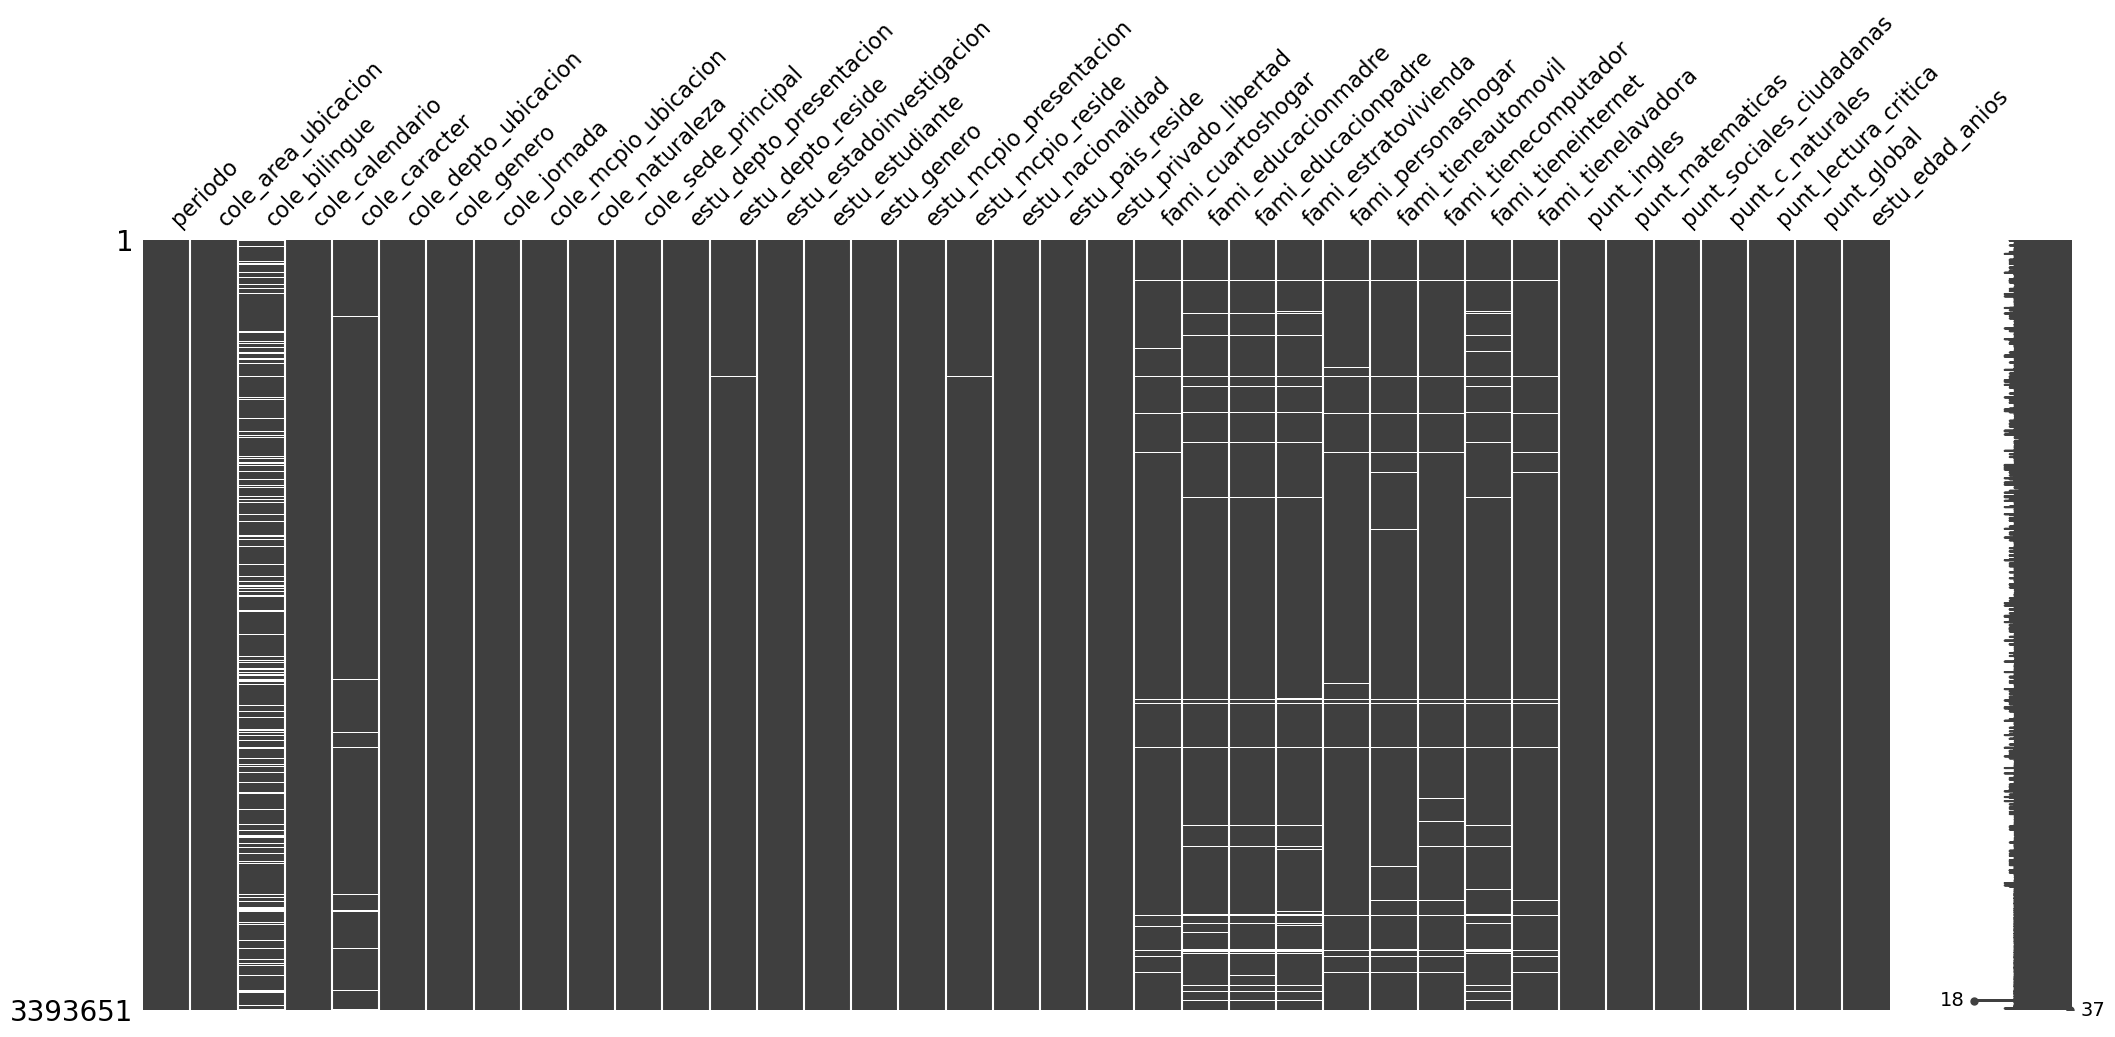

In [13]:
msno.matrix(saber11_df)

In [12]:
# Calcular conteo y porcentaje de faltantes en columnas categóricas
faltantes_cat = (
    saber11_df[categoricas]
    .isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "columna", 0: "missing_count"})
)

faltantes_cat["missing_pct"] = 100 * faltantes_cat["missing_count"] / len(saber11_df)

# Ordenar de mayor a menor porcentaje de faltantes
faltantes_cat = faltantes_cat.sort_values(by="missing_pct", ascending=False).reset_index(drop=True)

# Mostrar las primeras filas
print(faltantes_cat.head(30))  # puedes ajustar el número

                     columna  missing_count  missing_pct
0              cole_bilingue         480877    14.169901
1       fami_estratovivienda         107490     3.167385
2         fami_tieneinternet          98634     2.906427
3        fami_educacionpadre          96523     2.844223
4        fami_educacionmadre          96486     2.843133
5        fami_tieneautomovil          62610     1.844916
6              cole_caracter          60265     1.775816
7         fami_personashogar          59771     1.761259
8          fami_cuartoshogar          59011     1.738865
9       fami_tienecomputador          58991     1.738275
10        fami_tienelavadora          58256     1.716617
11               estu_genero           3085     0.090905
12         estu_depto_reside           1675     0.049357
13         estu_mcpio_reside           1675     0.049357
14   estu_depto_presentacion             86     0.002534
15   estu_mcpio_presentacion             86     0.002534
16       cole_area_ubicacion   

  cole_bilingue    count        mean  median        std
0             N  2850113  254.072731   251.0  48.966116
1    No_reporta   480877  244.255643   240.0  48.886747
2             S    62661  293.689280   301.0  68.856198


<Figure size 800x500 with 0 Axes>

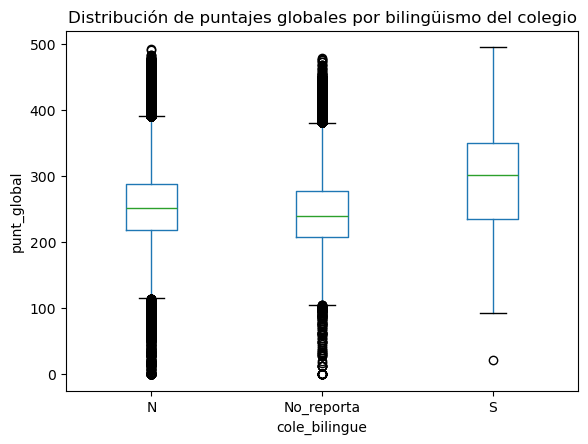

In [13]:
# Reemplazar NaN por categoría explícita
saber11_df["cole_bilingue"] = saber11_df["cole_bilingue"].fillna("No_reporta")

# Promedio, mediana y desviación estándar del puntaje global por categoría
resumen_bilingue = (
    saber11_df.groupby("cole_bilingue")["punt_global"]
    .agg(["count", "mean", "median", "std"])
    .reset_index()
)

print(resumen_bilingue)


plt.figure(figsize=(8,5))
saber11_df.boxplot(column="punt_global", by="cole_bilingue", grid=False)
plt.title("Distribución de puntajes globales por bilingüismo del colegio")
plt.suptitle("")
plt.xlabel("cole_bilingue")
plt.ylabel("punt_global")
plt.show()

In [14]:
from scipy.stats import mannwhitneyu

grupo_n = saber11_df.loc[saber11_df["cole_bilingue"] == "N", "punt_global"].dropna()
grupo_nr = saber11_df.loc[saber11_df["cole_bilingue"] == "No_reporta", "punt_global"].dropna()

stat, p = mannwhitneyu(grupo_n, grupo_nr)
print(f"Estadístico U = {stat:.3f}, p-valor = {p:.4f}")

Estadístico U = 765528602907.000, p-valor = 0.0000


In [15]:
# Mostrar tamaño original
print("Tamaño original del DataFrame:", saber11_df.shape)

# Eliminar todas las filas que tengan al menos un dato faltante
saber11_df = saber11_df.dropna()

# Mostrar tamaño final
print("Tamaño después de eliminar filas con algún valor faltante:", saber11_df.shape)

# Verificar si aún quedan valores faltantes
print("\nValores faltantes restantes por columna:")
print(saber11_df.isna().sum().sum(), "en total")

Tamaño original del DataFrame: (3393651, 36)
Tamaño después de eliminar filas con algún valor faltante: (3172551, 36)

Valores faltantes restantes por columna:
0 en total


<Axes: >

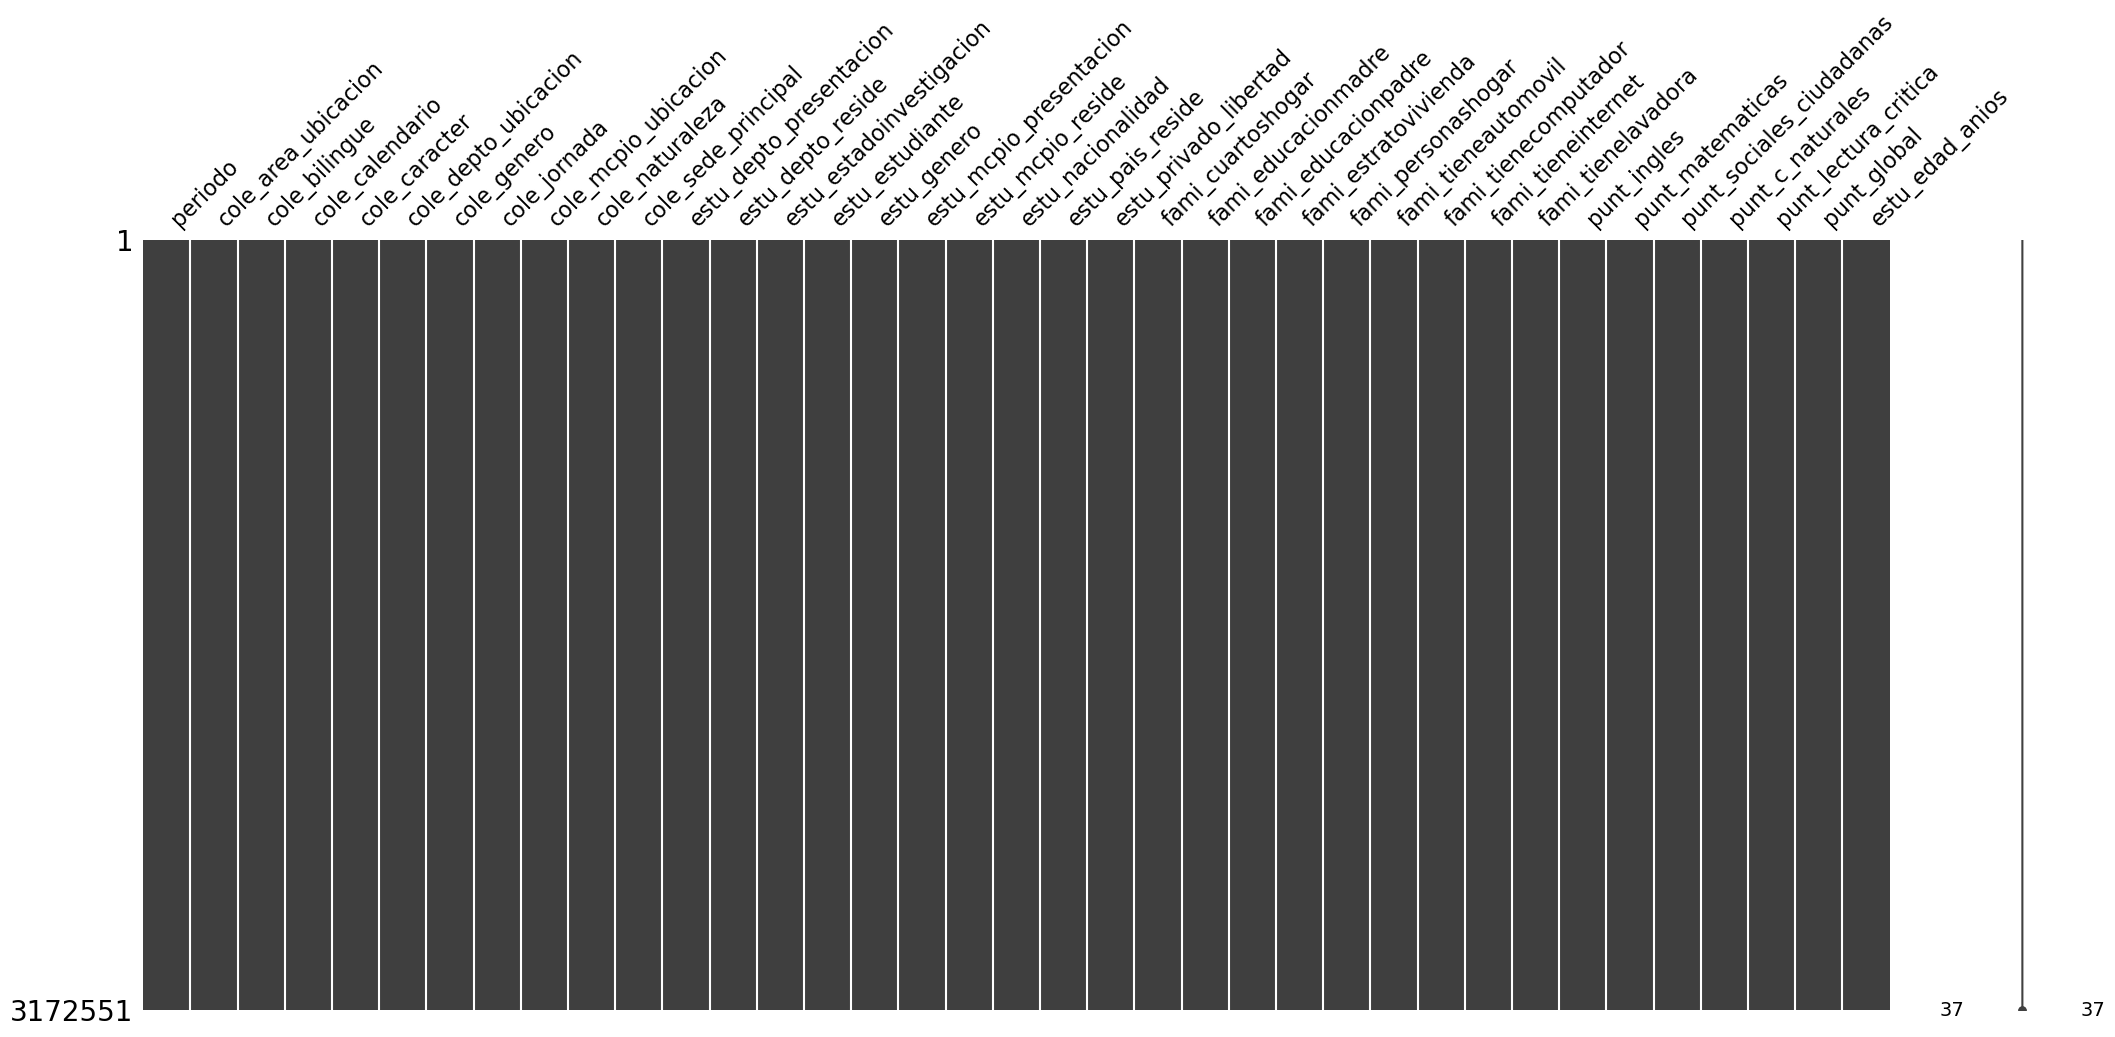

In [19]:
msno.matrix(saber11_df)

In [31]:
# Guardar el DataFrame limpio
saber11_df.to_parquet("saber11_limpio.parquet", index=False, engine="pyarrow")

In [4]:
saber11_df = pd.read_parquet("saber11_limpio.parquet")
saber11_df.shape[0]

3172551

In [16]:
saber11_df.head()

,periodo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_sede_principal,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global,estu_edad_anios
0,20194,RURAL,N,A,TÉCNICO/ACADÉMICO,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,N,HUILA,HUILA,PUBLICAR,ESTUDIANTE,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,71.0,66.0,70.0,65.0,69.0,339.0,16.0
1,20194,URBANO,N,A,TÉCNICO/ACADÉMICO,HUILA,MIXTO,COMPLETA,LA PLATA,OFICIAL,S,HUILA,HUILA,PUBLICAR,ESTUDIANTE,F,LA PLATA,LA PLATA,COLOMBIA,COLOMBIA,N,Dos,Primaria incompleta,Primaria incompleta,Estrato 1,5 a 6,No,No,No,No,46.0,43.0,31.0,40.0,43.0,199.0,17.0
2,20162,URBANO,N,A,TÉCNICO/ACADÉMICO,VALLE,MIXTO,MAÑANA,CALI,OFICIAL,S,VALLE,VALLE,PUBLICAR,ESTUDIANTE,M,CALI,CALI,COLOMBIA,COLOMBIA,N,Cuatro,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,Estrato 5,Cinco,Si,Si,Si,Si,59.0,57.0,46.0,57.0,57.0,272.0,15.0
3,20172,URBANO,N,A,TÉCNICO/ACADÉMICO,ANTIOQUIA,MIXTO,SABATINA,MEDELLIN,NO OFICIAL,S,ANTIOQUIA,ANTIOQUIA,PUBLICAR,ESTUDIANTE,F,ITAGÜÍ,MEDELLÍN,COLOMBIA,COLOMBIA,N,Cinco,Secundaria (Bachillerato) incompleta,Primaria incompleta,Estrato 2,5 a 6,No,No,Si,Si,44.0,53.0,54.0,44.0,54.0,253.0,17.0
4,20142,RURAL,N,A,TÉCNICO/ACADÉMICO,TOLIMA,MIXTO,MAÑANA,SAN LUIS,OFICIAL,S,TOLIMA,TOLIMA,PUBLICAR,ESTUDIANTE,M,GUAMO,SAN LUIS,COLOMBIA,COLOMBIA,N,Dos,Primaria incompleta,Primaria incompleta,Estrato 1,Cuatro,No,No,No,No,42.0,45.0,47.0,43.0,35.0,212.0,18.0


In [16]:
# Clasificar las columnas en numéricas y categóricas
numericas = saber11_df.select_dtypes(include=[np.number]).columns.tolist()
categoricas = saber11_df.select_dtypes(include=[object]).columns.tolist()

# Mostrar las columnas clasificadas
print("Columnas numéricas:")
print(numericas)

print("\nColumnas categóricas:")
print(categoricas)

Columnas numéricas:
['punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica', 'punt_global', 'estu_edad_anios']

Columnas categóricas:
['cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_sede_principal', 'estu_depto_presentacion', 'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_estudiante', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora']


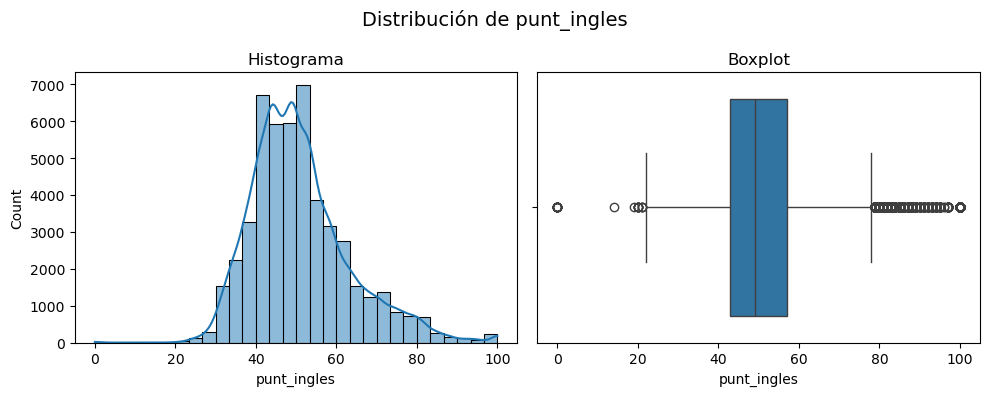

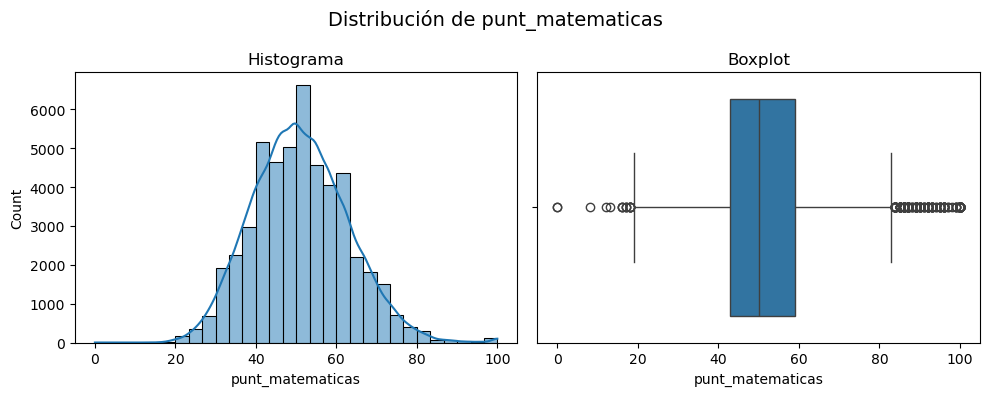

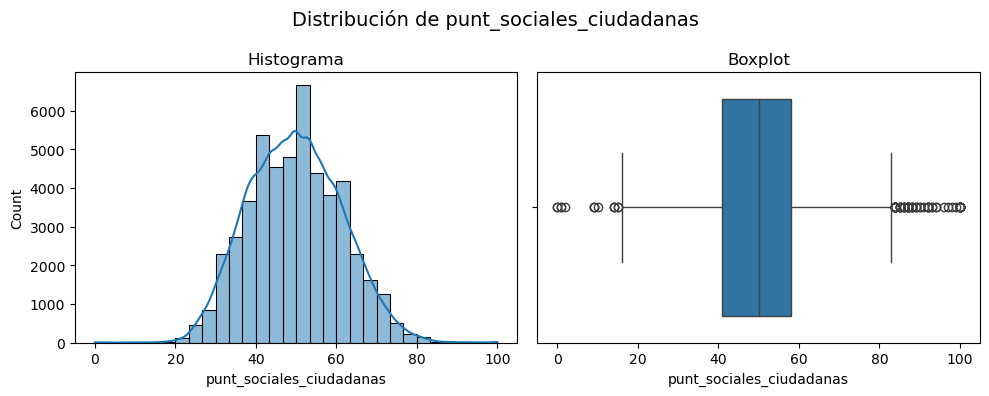

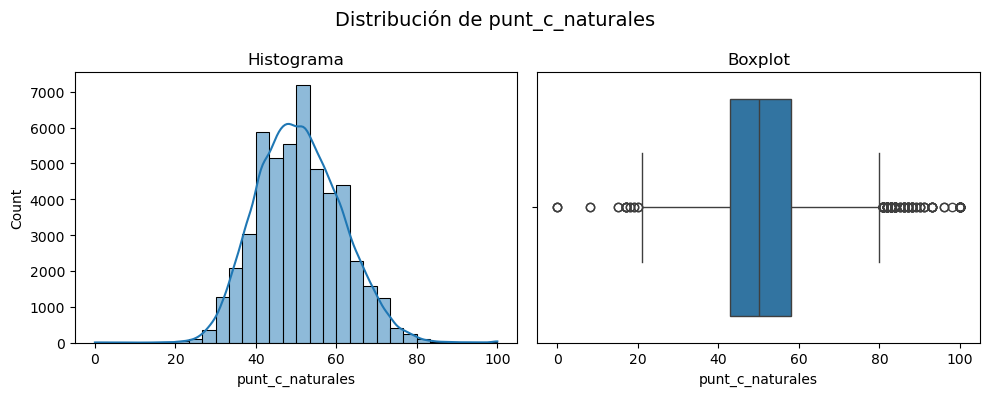

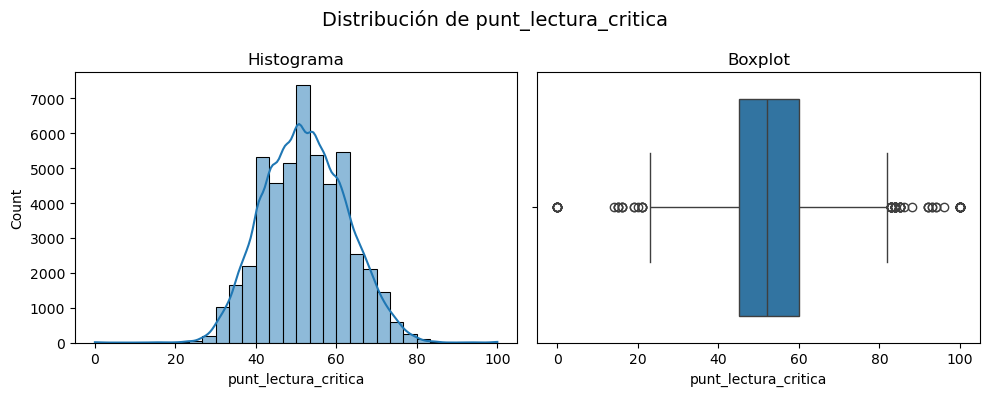

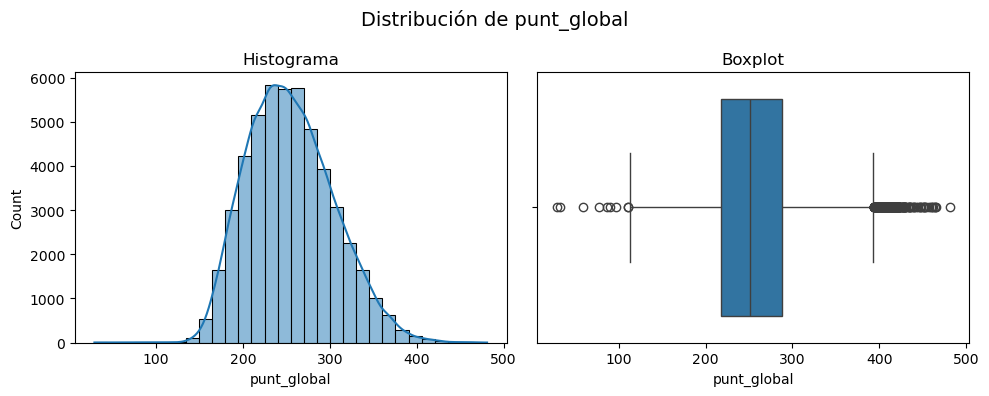

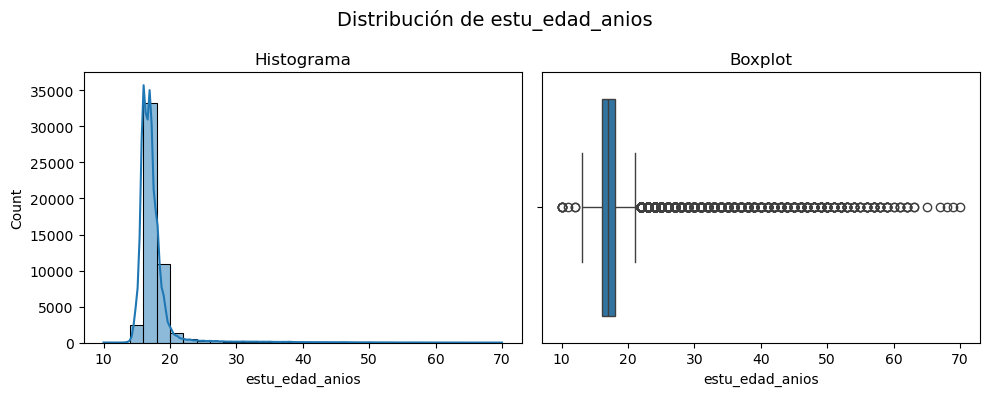

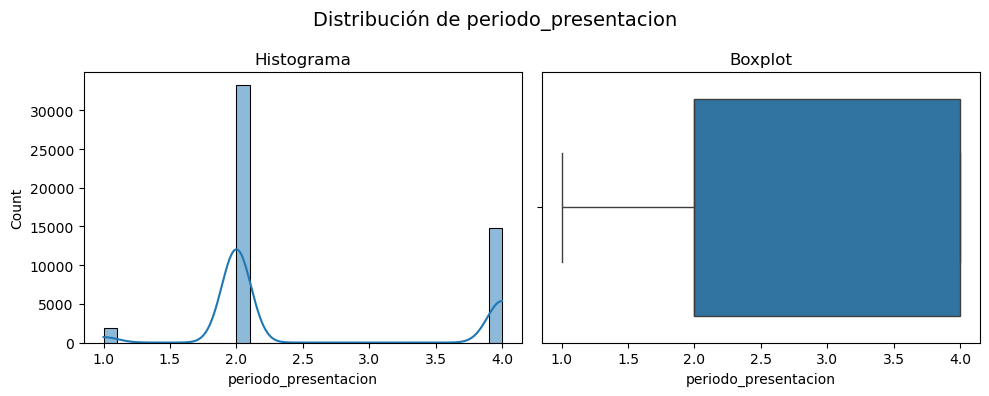

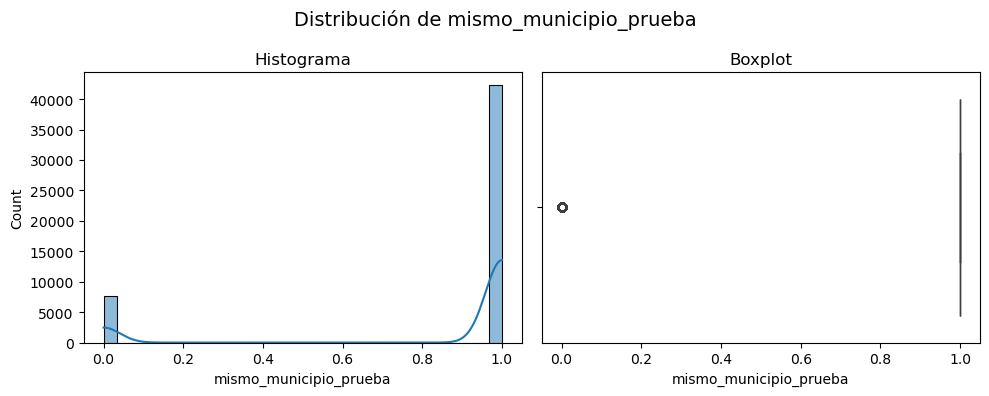

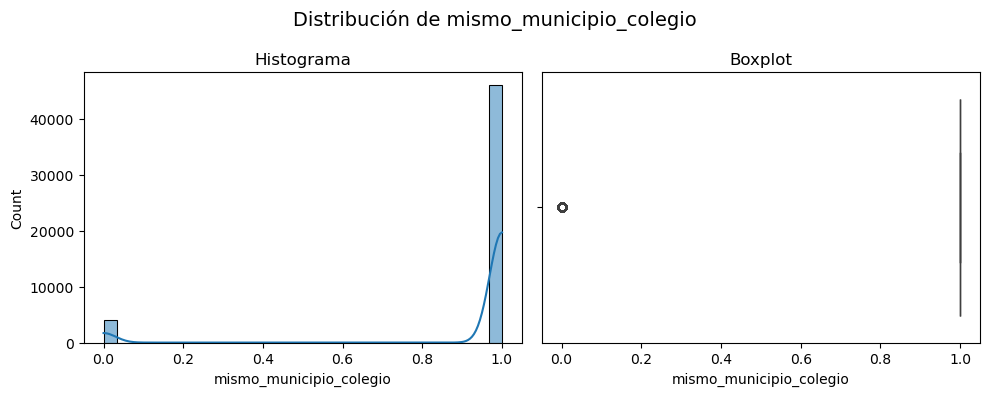

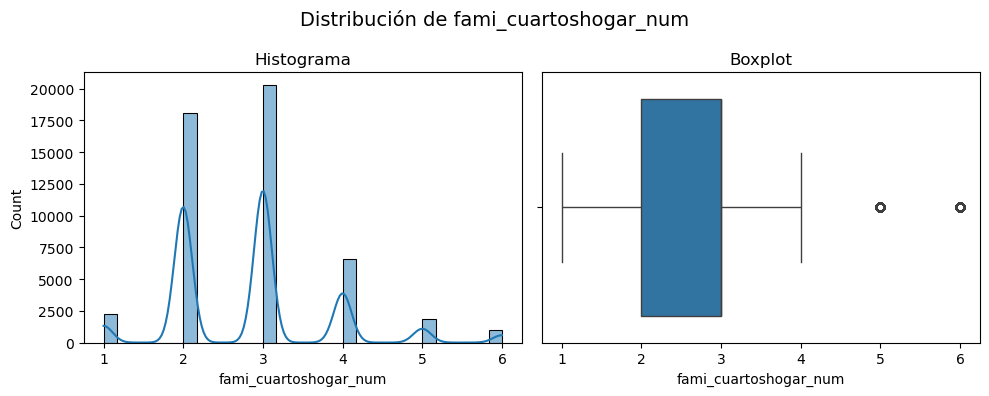

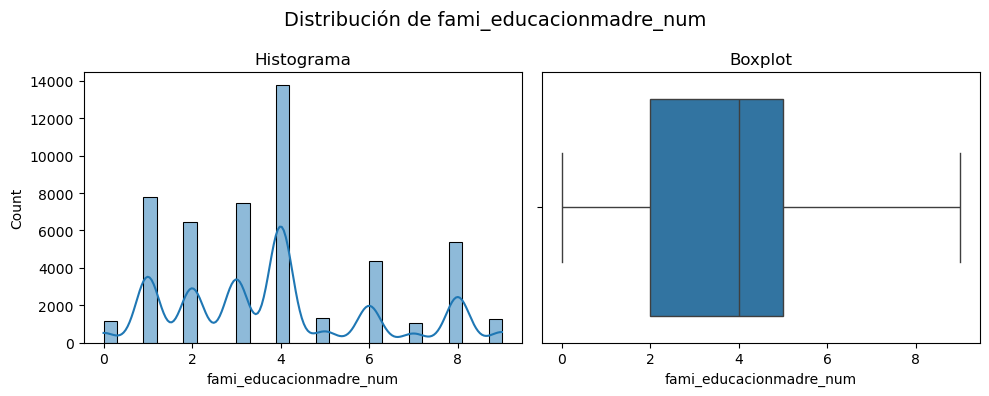

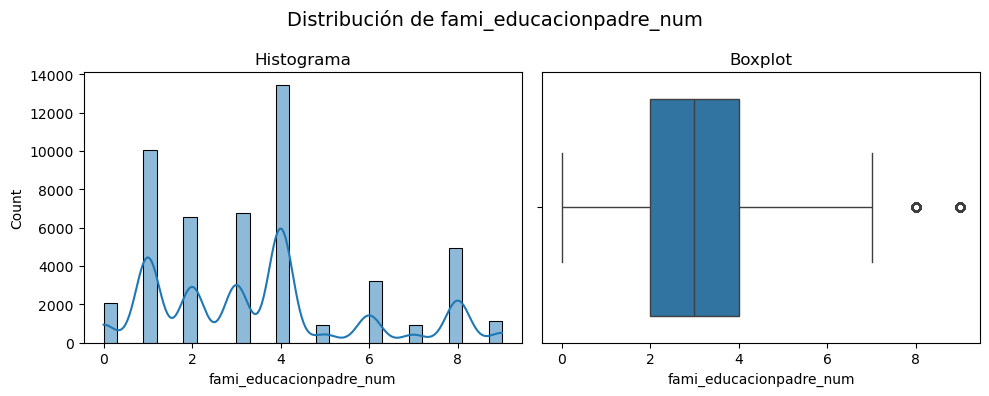

In [37]:
sample_df = saber11_df[numericas].sample(n=50000, random_state=42)  # muestra representativa

for col in numericas:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Distribución de {col}", fontsize=14)
    
    sb.histplot(sample_df[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title("Histograma")

    sb.boxplot(x=sample_df[col], ax=axes[1])
    axes[1].set_title("Boxplot")

    plt.tight_layout()
    plt.show()

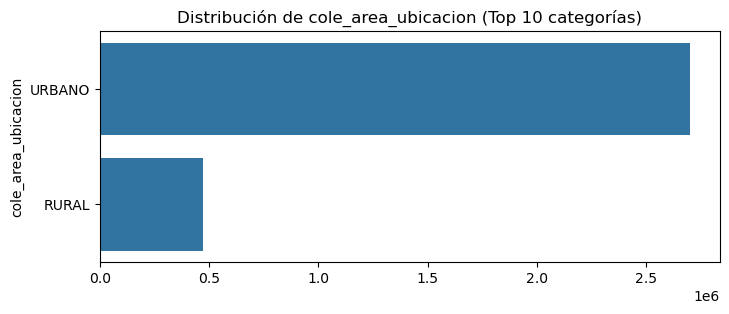

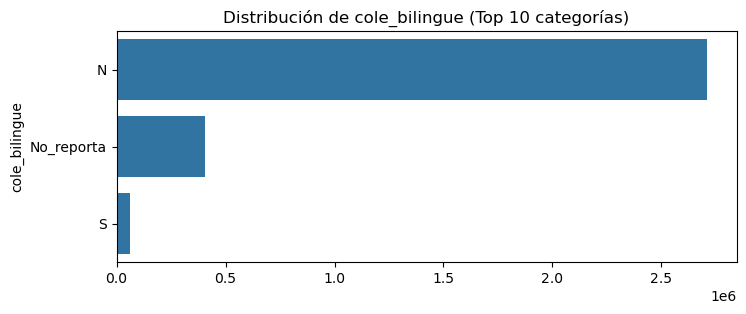

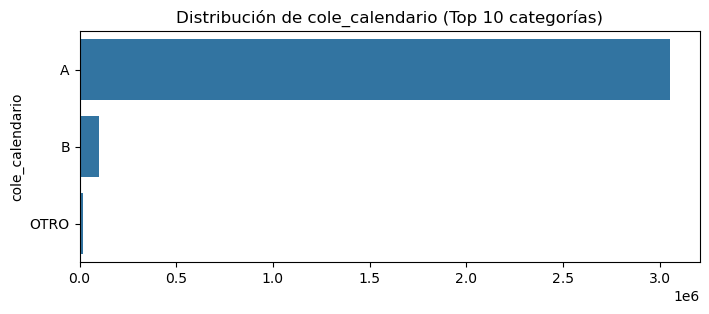

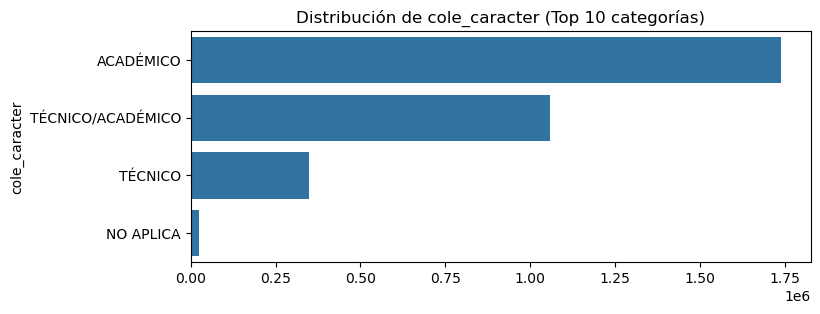

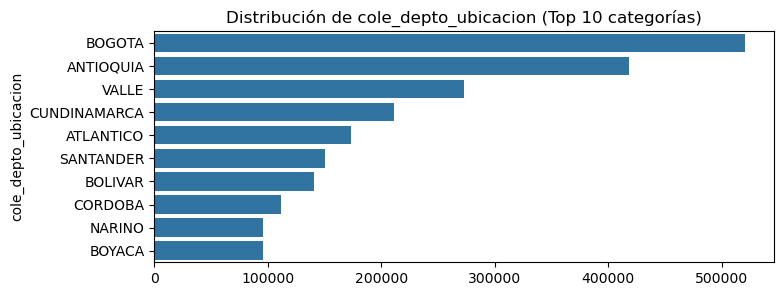

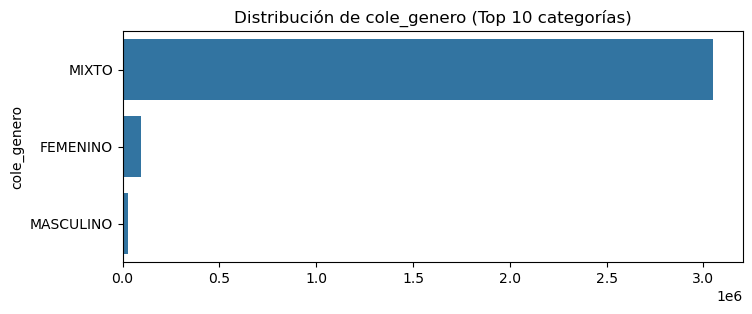

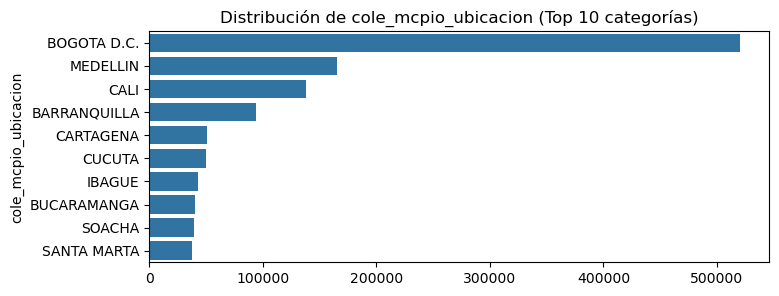

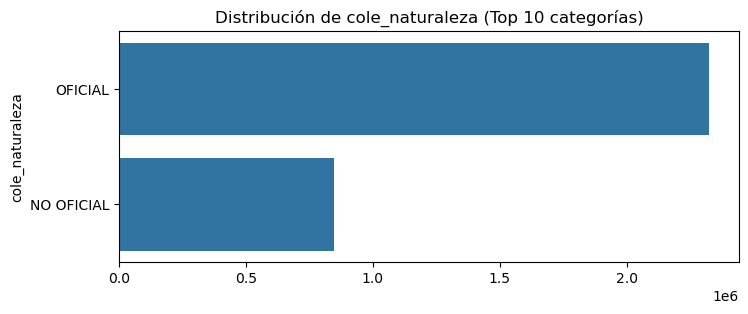

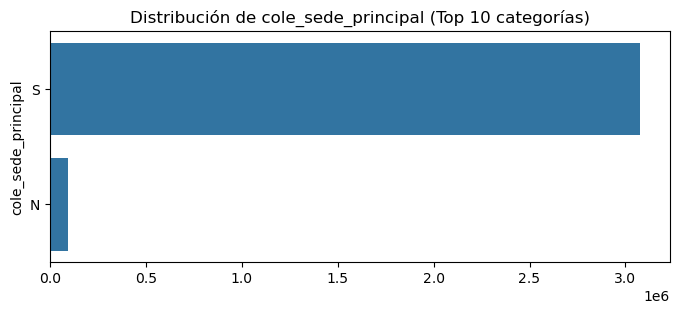

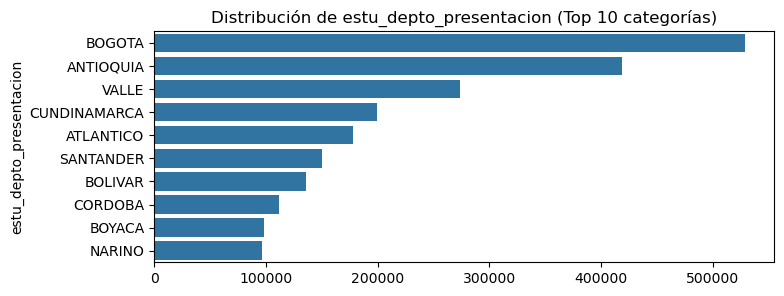

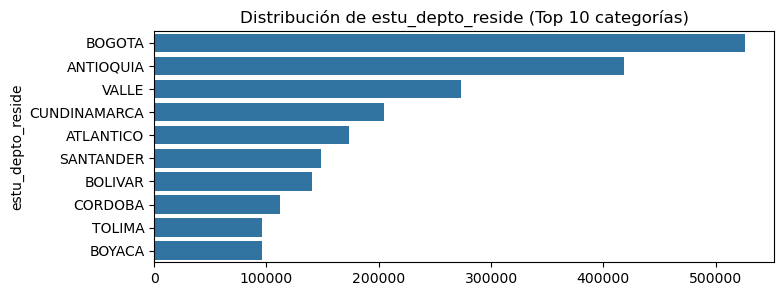

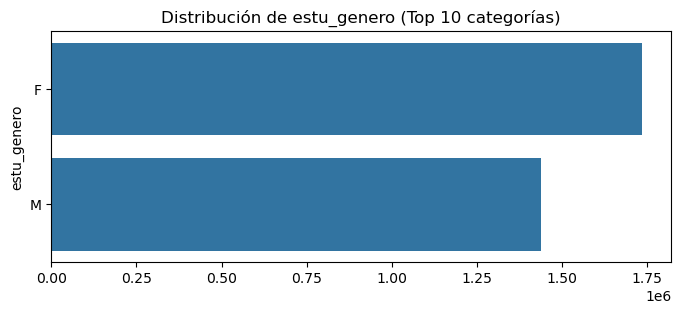

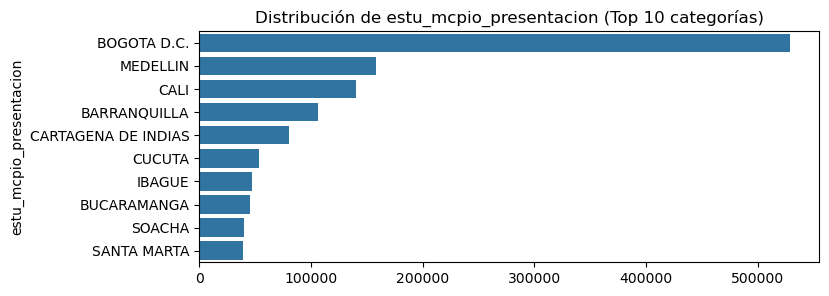

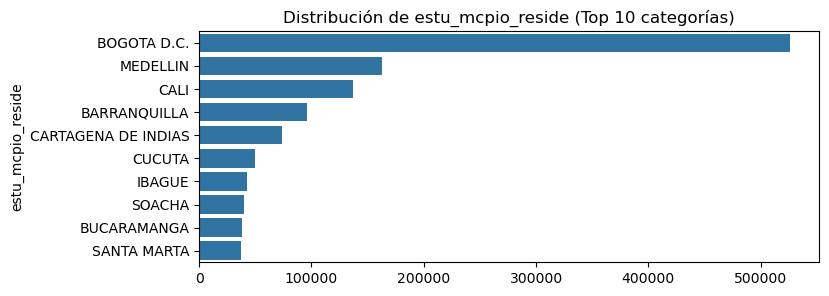

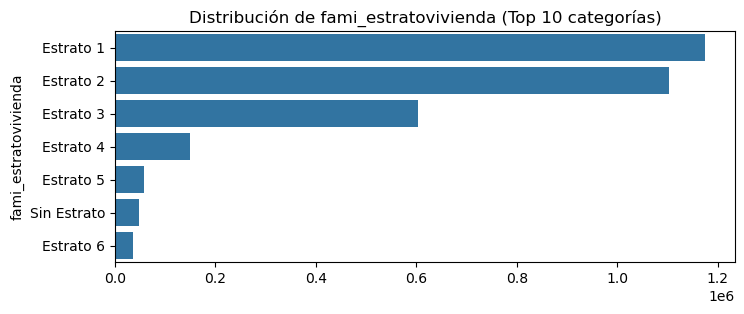

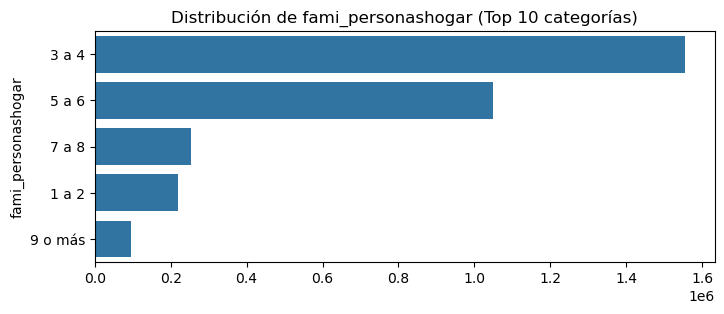

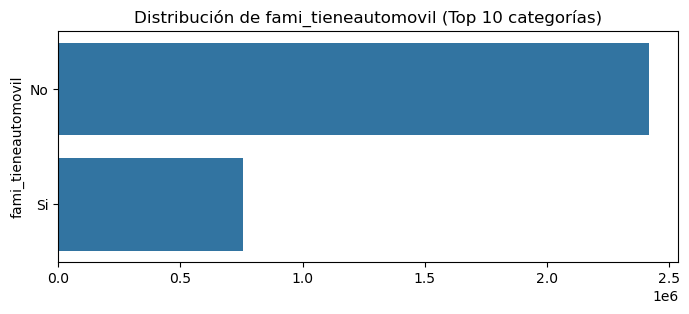

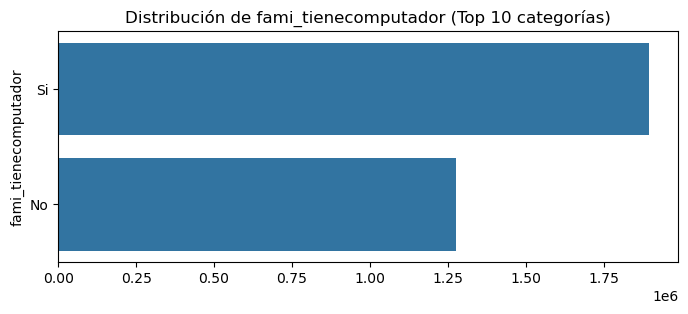

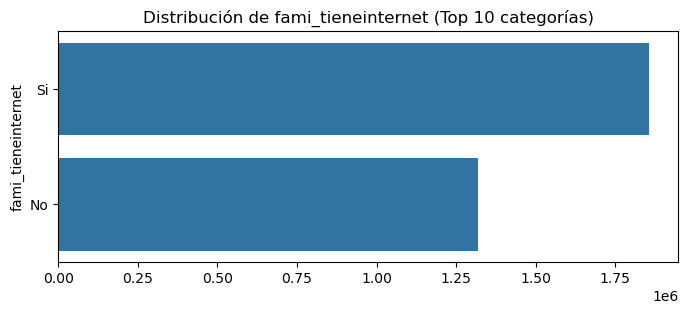

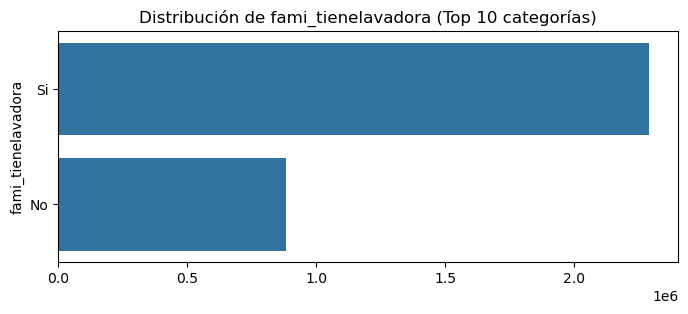

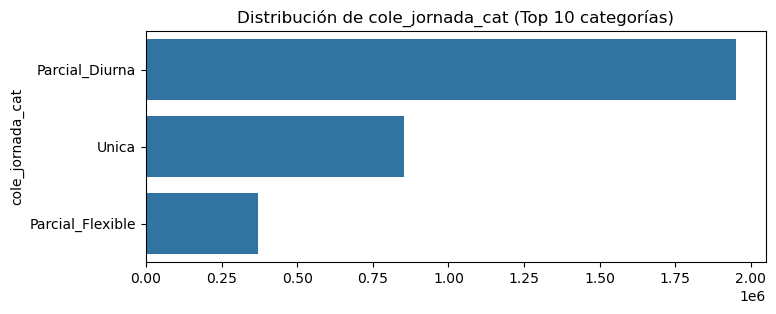

In [38]:
for col in categoricas:
    top = saber11_df[col].value_counts().nlargest(10)
    plt.figure(figsize=(8, 3))
    sb.barplot(x=top.values, y=top.index)
    plt.title(f"Distribución de {col} (Top 10 categorías)")
    plt.show()

In [17]:
cols_a_eliminar = [
    'estu_estadoinvestigacion', 'estu_estudiante', 'estu_nacionalidad',
    'estu_pais_reside', 'estu_privado_libertad', 'periodo'
]

saber11_df = saber11_df.drop(columns=[c for c in cols_a_eliminar if c in saber11_df.columns])

In [18]:
import unidecode

# === 1. Copiar las columnas relevantes ===
df_geo = saber11_df[[
    'cole_depto_ubicacion', 'cole_mcpio_ubicacion',
    'estu_depto_presentacion', 'estu_depto_reside',
    'estu_mcpio_presentacion', 'estu_mcpio_reside'
]].copy()

# === 2. Normalizar los textos ===
def normalizar_texto(texto):
    if pd.isna(texto):
        return None
    texto = texto.strip().upper()
    texto = unidecode.unidecode(texto)  # elimina tildes
    return texto

for col in df_geo.columns:
    df_geo[col] = df_geo[col].apply(normalizar_texto)

# === 3. Crear diccionarios de equivalencias únicos ===
dptos_unicos = pd.unique(
    pd.concat([
        df_geo['cole_depto_ubicacion'],
        df_geo['estu_depto_presentacion'],
        df_geo['estu_depto_reside']
    ])
)
dicc_dptos = {d: d for d in sorted(dptos_unicos) if pd.notna(d)}

muns_unicos = pd.unique(
    pd.concat([
        df_geo['cole_mcpio_ubicacion'],
        df_geo['estu_mcpio_presentacion'],
        df_geo['estu_mcpio_reside']
    ])
)
dicc_muns = {m: m for m in sorted(muns_unicos) if pd.notna(m)}

# === 4. Aplicar los diccionarios (opcional, en este caso son identidad) ===
for col in ['cole_depto_ubicacion', 'estu_depto_presentacion', 'estu_depto_reside']:
    df_geo[col] = df_geo[col].map(dicc_dptos)

for col in ['cole_mcpio_ubicacion', 'estu_mcpio_presentacion', 'estu_mcpio_reside']:
    df_geo[col] = df_geo[col].map(dicc_muns)

# === 5. Crear la variable auxiliar ===
df_geo['mismo_municipio_prueba'] = (
    df_geo['estu_mcpio_presentacion'] == df_geo['estu_mcpio_reside']
).astype(int)

# === 6. Reemplazar las columnas originales en saber11_df con las versiones limpias ===
for col in df_geo.columns:
    saber11_df[col] = df_geo[col]

# === 7. Validación rápida ===
print("Distribución de la variable 'mismo_municipio_prueba':")
print(saber11_df['mismo_municipio_prueba'].value_counts(normalize=True))


Distribución de la variable 'mismo_municipio_prueba':
mismo_municipio_prueba
1    0.844371
0    0.155629
Name: proportion, dtype: float64


In [19]:
# Crear la nueva variable
saber11_df['mismo_municipio_colegio'] = (
    saber11_df['estu_mcpio_reside'] == saber11_df['cole_mcpio_ubicacion']
).astype(int)

# Validación rápida
print("Distribución de la variable 'mismo_municipio_colegio':")
print(saber11_df['mismo_municipio_colegio'].value_counts(normalize=True))

Distribución de la variable 'mismo_municipio_colegio':
mismo_municipio_colegio
1    0.920705
0    0.079295
Name: proportion, dtype: float64


In [20]:
# Diccionario de agrupación
mapa_jornada = {
    'COMPLETA': 'Unica',
    'UNICA': 'Unica',
    'MAÑANA': 'Parcial_Diurna',
    'TARDE': 'Parcial_Diurna',
    'NOCHE': 'Parcial_Flexible',
    'SABATINA': 'Parcial_Flexible'
}

# Crear nueva columna con la categoría agrupada
saber11_df['cole_jornada_cat'] = saber11_df['cole_jornada'].replace(mapa_jornada)

# Eliminar la columna original
saber11_df.drop(columns=['cole_jornada'], inplace=True)

# Verificar el resultado
print(saber11_df['cole_jornada_cat'].value_counts(dropna=False))

cole_jornada_cat
Parcial_Diurna      1951735
Unica                851486
Parcial_Flexible     369330
Name: count, dtype: int64


In [27]:
print(saber11_df['fami_cuartoshogar'].value_counts(normalize=True))

# Diccionario de mapeo
mapa_cuartos = {
    'Uno': 1,
    'Dos': 2,
    'Tres': 3,
    'Cuatro': 4,
    'Cinco': 5,
    'Seis': 6,
    'Seis o mas': 6,
    'Siete': 6,
    'Ocho': 6,
    'Nueve': 6,
    'Diez o más': 6
}

# Aplicar el mapeo
saber11_df['fami_cuartoshogar_num'] = saber11_df['fami_cuartoshogar'].replace(mapa_cuartos).astype(int)

# Eliminar la columna original
saber11_df.drop(columns=['fami_cuartoshogar'], inplace=True)

# Verificar resultado
print(saber11_df['fami_cuartoshogar_num'].value_counts(normalize=True))

fami_cuartoshogar
Tres          0.406959
Dos           0.361389
Cuatro        0.130397
Uno           0.045398
Cinco         0.036369
Seis o mas    0.009458
Seis          0.005914
Siete         0.002097
Ocho          0.001086
Diez o más    0.000555
Nueve         0.000379
Name: proportion, dtype: float64
fami_cuartoshogar_num
3    0.406959
2    0.361389
4    0.130397
1    0.045398
5    0.036369
6    0.019489
Name: proportion, dtype: float64


In [21]:
saber11_df['fami_personashogar'].unique()

print(saber11_df['fami_personashogar'].value_counts(normalize=True))

mapeo_personas = {
    "Una": "1 a 2",
    "Dos": "1 a 2",
    "Tres": "3 a 4",
    "Cuatro": "3 a 4",
    "Cinco": "5 a 6",
    "Seis": "5 a 6",
    "Siete": "7 a 8",
    "Ocho": "7 a 8",
    "Nueve": "9 o más",
    "Diez": "9 o más",
    "Once": "9 o más",
    "Doce o más": "9 o más"
}

# Aplicamos el reemplazo
saber11_df["fami_personashogar"] = saber11_df["fami_personashogar"].replace(mapeo_personas)

# Ahora revisamos la distribución final
print(saber11_df["fami_personashogar"].value_counts(normalize=True))

fami_personashogar
3 a 4         0.239984
Cuatro        0.159434
5 a 6         0.148303
Cinco         0.122124
Tres          0.090995
Seis          0.059960
1 a 2         0.038751
7 a 8         0.036890
Siete         0.028053
Dos           0.027148
Ocho          0.014982
9 o más       0.014280
Nueve         0.006384
Diez          0.004441
Doce o más    0.003372
Una           0.002939
Once          0.001960
Name: proportion, dtype: float64
fami_personashogar
3 a 4      0.490412
5 a 6      0.330387
7 a 8      0.079925
1 a 2      0.068839
9 o más    0.030437
Name: proportion, dtype: float64


In [22]:
set(saber11_df['fami_educacionmadre'].unique()) == set(saber11_df['fami_educacionpadre'].unique())

True

In [23]:
saber11_df['fami_educacionmadre'] = saber11_df['fami_educacionmadre'].replace(['No Aplica', 'No sabe'], np.nan)
saber11_df['fami_educacionpadre'] = saber11_df['fami_educacionpadre'].replace(['No Aplica', 'No sabe'], np.nan)

In [24]:
# Imputar educación madre
saber11_df['fami_educacionmadre'] = (
    saber11_df.groupby('fami_estratovivienda')['fami_educacionmadre']
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
)

# Imputar educación padre
saber11_df['fami_educacionpadre'] = (
    saber11_df.groupby('fami_estratovivienda')['fami_educacionpadre']
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
)

In [25]:
nivel_educativo = {
    'Ninguno': 0,
    'Primaria incompleta': 1,
    'Primaria completa': 2,
    'Secundaria (Bachillerato) incompleta': 3,
    'Secundaria (Bachillerato) completa': 4,
    'Técnica o tecnológica incompleta': 5,
    'Técnica o tecnológica completa': 6,
    'Educación profesional incompleta': 7,
    'Educación profesional completa': 8,
    'Postgrado': 9
}

saber11_df['fami_educacionmadre_num'] = saber11_df['fami_educacionmadre'].map(nivel_educativo)
saber11_df['fami_educacionpadre_num'] = saber11_df['fami_educacionpadre'].map(nivel_educativo)

# Eliminar las columnas originales
saber11_df.drop(columns=['fami_educacionmadre'], inplace=True)
saber11_df.drop(columns=['fami_educacionpadre'], inplace=True)

In [30]:
saber11_df.head()

,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_depto_ubicacion,cole_genero,cole_naturaleza,cole_sede_principal,estu_depto_presentacion,estu_depto_reside,estu_genero,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global,estu_edad_anios,mismo_municipio_prueba,mismo_municipio_colegio,cole_jornada_cat,fami_educacionmadre_num,fami_educacionpadre_num,fami_cuartoshogar_num
1,RURAL,N,A,TÉCNICO/ACADÉMICO,HUILA,MIXTO,OFICIAL,N,HUILA,HUILA,F,Estrato 2,1 a 2,No,Si,Si,Si,71.0,66.0,70.0,65.0,69.0,339.0,16.0,1,1,Unica,9,2,2
5,URBANO,N,A,TÉCNICO/ACADÉMICO,HUILA,MIXTO,OFICIAL,S,HUILA,HUILA,F,Estrato 1,5 a 6,No,No,No,No,46.0,43.0,31.0,40.0,43.0,199.0,17.0,1,1,Unica,1,1,2
7,URBANO,N,A,TÉCNICO/ACADÉMICO,VALLE,MIXTO,OFICIAL,S,VALLE,VALLE,M,Estrato 5,5 a 6,Si,Si,Si,Si,59.0,57.0,46.0,57.0,57.0,272.0,15.0,1,1,Parcial_Diurna,3,4,4
9,URBANO,N,A,TÉCNICO/ACADÉMICO,ANTIOQUIA,MIXTO,NO OFICIAL,S,ANTIOQUIA,ANTIOQUIA,F,Estrato 2,5 a 6,No,No,Si,Si,44.0,53.0,54.0,44.0,54.0,253.0,17.0,0,1,Parcial_Flexible,3,1,5
11,RURAL,N,A,TÉCNICO/ACADÉMICO,TOLIMA,MIXTO,OFICIAL,S,TOLIMA,TOLIMA,M,Estrato 1,3 a 4,No,No,No,No,42.0,45.0,47.0,43.0,35.0,212.0,18.0,0,1,Parcial_Diurna,1,1,2


# Análisis bivariado

In [ ]:
saber11_df = pd.read_parquet("saber11_limpio.parquet")
saber11_df.shape

In [61]:
saber11_df.shape

(3172551, 31)

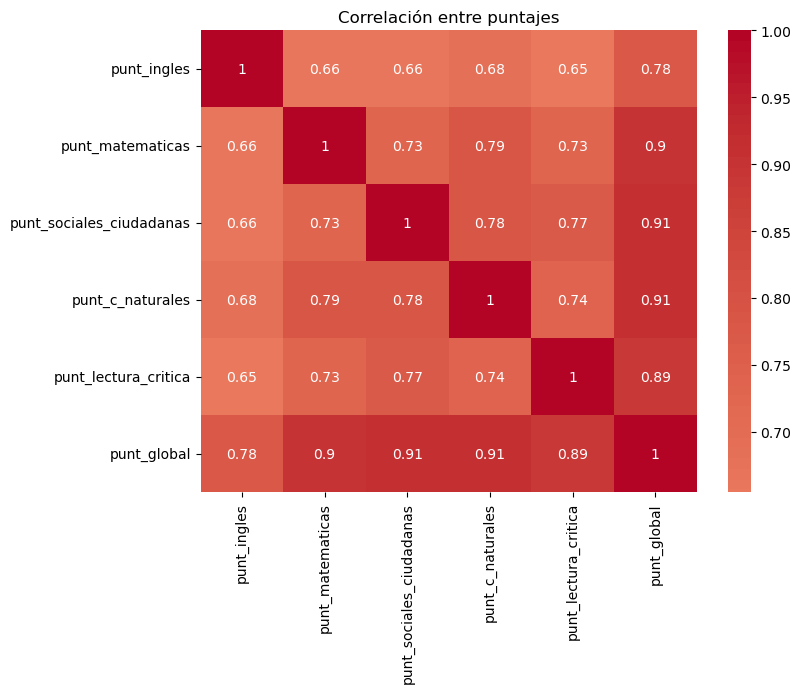

=== Correlación entre las variables objetivo ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
punt_ingles,1.000000,0.661156,0.662407,0.683189,0.654762,0.778012
punt_matematicas,0.661156,1.000000,0.730218,0.786290,0.727819,0.900148
punt_sociales_ciudadanas,0.662407,0.730218,1.000000,0.783207,0.771803,0.907432
punt_c_naturales,0.683189,0.786290,0.783207,1.000000,0.739221,0.911867
punt_lectura_critica,0.654762,0.727819,0.771803,0.739221,1.000000,0.888725
punt_global,0.778012,0.900148,0.907432,0.911867,0.888725,1.000000


In [55]:
targets = [
    'punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas',
    'punt_c_naturales', 'punt_lectura_critica', 'punt_global'
]

corr_targets = saber11_df[targets].corr()

plt.figure(figsize=(8,6))
sb.heatmap(corr_targets, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre puntajes')
plt.show()

print("=== Correlación entre las variables objetivo ===")
display(corr_targets)

In [56]:
corr_with_targets = pd.DataFrame({
    t: saber11_df[numericas].corrwith(saber11_df[t]) for t in targets
})

corr_with_targets

,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
punt_ingles,1.000000,0.661156,0.662407,0.683189,0.654762,0.778012
punt_matematicas,0.661156,1.000000,0.730218,0.786290,0.727819,0.900148
punt_sociales_ciudadanas,0.662407,0.730218,1.000000,0.783207,0.771803,0.907432
punt_c_naturales,0.683189,0.786290,0.783207,1.000000,0.739221,0.911867
punt_lectura_critica,0.654762,0.727819,0.771803,0.739221,1.000000,0.888725
punt_global,0.778012,0.900148,0.907432,0.911867,0.888725,1.000000
estu_edad_anios,-0.186376,-0.236102,-0.179392,-0.230324,-0.218546,-0.239284
periodo_presentacion,-0.113685,-0.023348,-0.155543,-0.129107,0.012467,-0.087336
mismo_municipio_prueba,0.119904,0.095157,0.098031,0.088896,0.115469,0.113176
mismo_municipio_colegio,-0.034450,0.000633,-0.013505,-0.008033,0.008504,-0.006638


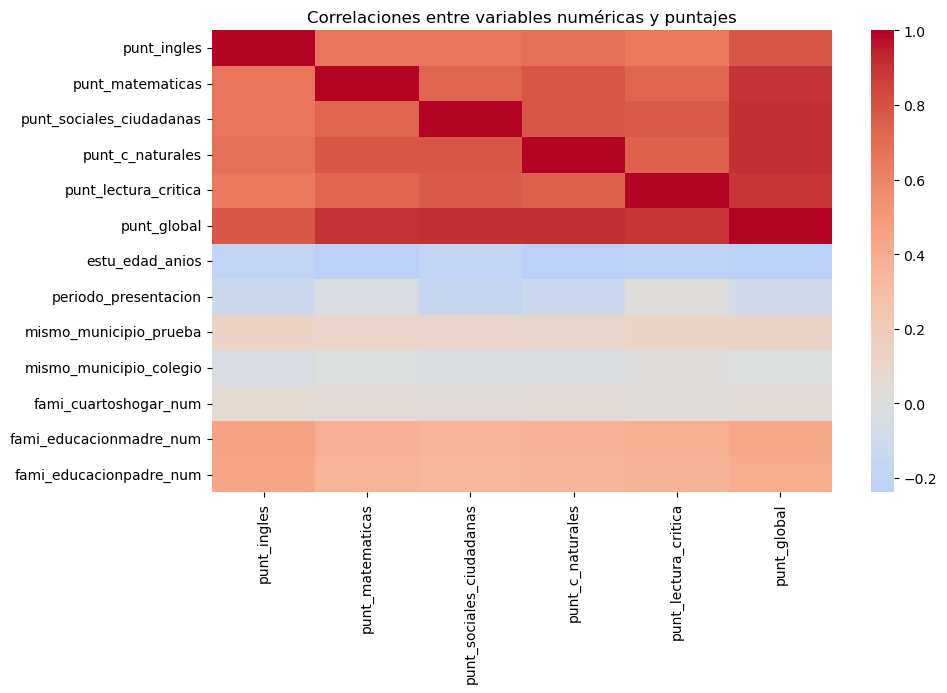

In [57]:
plt.figure(figsize=(10,6))
sb.heatmap(corr_with_targets, annot=False, cmap='coolwarm', center=0)
plt.title('Correlaciones entre variables numéricas y puntajes')
plt.show()

In [59]:
cat_cols = saber11_df.select_dtypes(include=['object']).columns

for col in cat_cols[:20]:  # ejemplo con 3 primeras, puedes ampliarlo
    print(f"\n=== {col} ===")
    display(
        saber11_df.groupby(col)[targets].mean().sort_values(by='punt_global', ascending=False)
    )



=== cole_area_ubicacion ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_area_ubicacion,,,,,,
URBANO,51.621129,51.696939,50.364059,51.377179,52.845641,257.874373
RURAL,46.969536,47.299434,46.156315,47.899406,48.636316,237.286659



=== cole_bilingue ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_bilingue,,,,,,
S,66.003351,59.793770,57.379199,58.164206,58.530269,295.234698
N,50.837187,51.128552,49.823805,50.926194,52.294720,255.137525
No_reporta,49.316910,49.172718,48.032785,49.334107,50.780661,246.646200



=== cole_calendario ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_calendario,,,,,,
B,69.928683,63.303079,60.933360,61.578400,62.072250,312.918610
A,50.313078,50.661183,49.383033,50.527817,51.908883,252.983377
OTRO,46.228592,44.865002,45.398447,45.150790,48.018038,229.433368



=== cole_caracter ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_caracter,,,,,,
ACADÉMICO,52.336883,51.725054,50.468994,51.524238,52.819108,258.442384
TÉCNICO/ACADÉMICO,49.435433,50.465193,49.122539,50.220188,51.748942,251.579456
TÉCNICO,48.702070,49.691780,48.267985,49.769424,50.855239,247.867685
NO APLICA,47.147481,46.710447,45.291151,46.788447,49.319869,235.183081



=== cole_depto_ubicacion ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_depto_ubicacion,,,,,,
BOGOTA,56.143569,55.095331,53.737234,54.640839,55.646966,274.425305
SANTANDER,52.159072,54.037180,51.621315,53.298429,54.024822,265.810149
BOYACA,51.701326,54.137817,51.793730,53.221314,53.379108,265.114839
CUNDINAMARCA,52.531901,52.859552,51.332847,52.445631,53.518950,262.692785
NORTE SANTANDER,50.465217,52.623279,49.928189,51.713405,52.745882,258.268514
RISARALDA,52.146895,51.339373,50.564159,51.502946,52.987070,258.204377
VALLE,51.923008,51.159810,50.445709,51.295528,53.106404,257.670919
QUINDIO,51.578095,51.160240,50.152113,50.906423,52.585994,256.157404
META,50.033093,51.492414,49.766516,50.963557,52.277993,255.205333



=== cole_genero ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_genero,,,,,,
MASCULINO,64.160696,62.710479,59.580554,60.661280,60.216186,305.257168
FEMENINO,61.001483,58.212519,57.068246,57.418848,59.204073,291.043961
MIXTO,50.495487,50.712569,49.420438,50.566100,51.929925,253.224389



=== cole_naturaleza ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_naturaleza,,,,,,
NO OFICIAL,57.650016,55.238377,53.857025,54.508014,55.849051,275.387190
OFICIAL,48.476327,49.511450,48.234800,49.528330,50.894706,247.302167



=== cole_sede_principal ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_sede_principal,,,,,,
S,51.053084,51.138071,49.838290,50.946171,52.291452,255.267637
N,46.928643,47.964908,46.503613,48.072100,49.893174,240.089453



=== estu_depto_presentacion ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
estu_depto_presentacion,,,,,,
BOGOTA,56.512030,55.318310,53.945174,54.842227,55.820245,275.496544
SANTANDER,52.188319,54.123994,51.664859,53.369123,54.074390,266.110536
BOYACA,51.556057,53.963848,51.663392,53.076105,53.253929,264.395958
CUNDINAMARCA,51.512667,52.219666,50.746746,51.868519,53.040389,259.667928
RISARALDA,52.209003,51.391719,50.618325,51.560414,53.035701,258.473746
NORTE SANTANDER,50.468767,52.613534,49.939280,51.700938,52.745258,258.256254
VALLE,51.917738,51.154979,50.436109,51.290642,53.101917,257.641424
QUINDIO,51.602544,51.213945,50.181142,50.945619,52.620903,256.348173
META,50.074496,51.551941,49.810333,51.005517,52.312505,255.428563



=== estu_depto_reside ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
estu_depto_reside,,,,,,
BOGOTA,56.482351,55.298643,53.925201,54.825580,55.809272,275.407451
SANTANDER,52.204196,54.118475,51.666676,53.366334,54.077546,266.112718
BOYACA,51.636862,54.094729,51.754858,53.184278,53.340996,264.908856
CUNDINAMARCA,51.620103,52.325366,50.836427,51.958115,53.090443,260.096196
NORTE SANTANDER,50.457000,52.612779,49.925409,51.707845,52.736427,258.232737
RISARALDA,52.130796,51.329192,50.553220,51.491579,52.978673,258.150962
VALLE,51.928837,51.163161,50.449424,51.299268,53.109729,257.689471
QUINDIO,51.571527,51.183580,50.158357,50.919565,52.597980,256.218184
META,50.056054,51.516401,49.789563,50.986792,52.301235,255.321852



=== estu_genero ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
estu_genero,,,,,,
M,51.470906,52.841655,50.351420,51.990364,52.316191,259.219435
F,50.479168,49.549505,49.228778,49.921302,52.138827,251.152073



=== fami_estratovivienda ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_estratovivienda,,,,,,
Estrato 6,72.740417,63.529565,60.556972,61.049782,61.525499,312.585790
Estrato 5,67.616220,61.200938,58.765861,59.375760,60.398664,302.628199
Estrato 4,62.707729,58.646659,56.510447,57.370874,58.722628,290.946980
Estrato 3,55.154863,54.388706,52.906475,53.708085,55.500517,271.025422
Estrato 2,50.381075,51.338623,49.982686,51.040469,52.602288,255.875008
Estrato 1,46.633379,47.520355,46.600759,47.966810,48.909129,238.317306
Sin Estrato,41.761954,42.691764,40.597803,43.169358,45.785979,214.810236



=== fami_personashogar ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_personashogar,,,,,,
3 a 4,52.508338,52.389586,51.056259,52.021674,53.463709,261.270636
1 a 2,51.472577,50.759178,49.986717,50.708806,52.728642,255.395093
5 a 6,49.737898,50.274711,48.881635,50.167303,51.336465,250.660629
7 a 8,47.371919,47.871880,46.613469,48.134612,49.302371,239.667850
9 o más,46.520520,46.640483,45.432940,47.149281,48.258381,234.218769



=== fami_tieneautomovil ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_tieneautomovil,,,,,,
Si,57.844781,56.222979,54.152613,55.197595,56.372323,278.338702
No,48.768872,49.424527,48.359049,49.504769,50.922114,247.462156



=== fami_tienecomputador ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_tienecomputador,,,,,,
Si,54.174646,53.724679,52.314232,53.210512,54.560594,267.540643
No,46.112828,47.062723,45.915078,47.371375,48.745104,235.921687



=== fami_tieneinternet ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_tieneinternet,,,,,,
Si,54.237644,53.777271,52.179068,53.100363,54.788814,267.605685
No,46.269580,47.191505,46.300259,47.704280,48.600793,236.792833



=== fami_tienelavadora ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
fami_tienelavadora,,,,,,
Si,52.479856,52.356941,50.829891,51.896513,53.451116,260.801414
No,46.911659,47.637969,46.909423,48.173948,49.028444,239.293467



=== cole_jornada_cat ===


,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
cole_jornada_cat,,,,,,
Unica,56.609238,55.766709,53.576704,54.690882,56.080368,275.751316
Parcial_Diurna,49.895686,50.642676,49.438966,50.637174,51.872826,252.950606
Parcial_Flexible,43.293342,42.264292,42.467468,43.202586,45.148301,216.362781


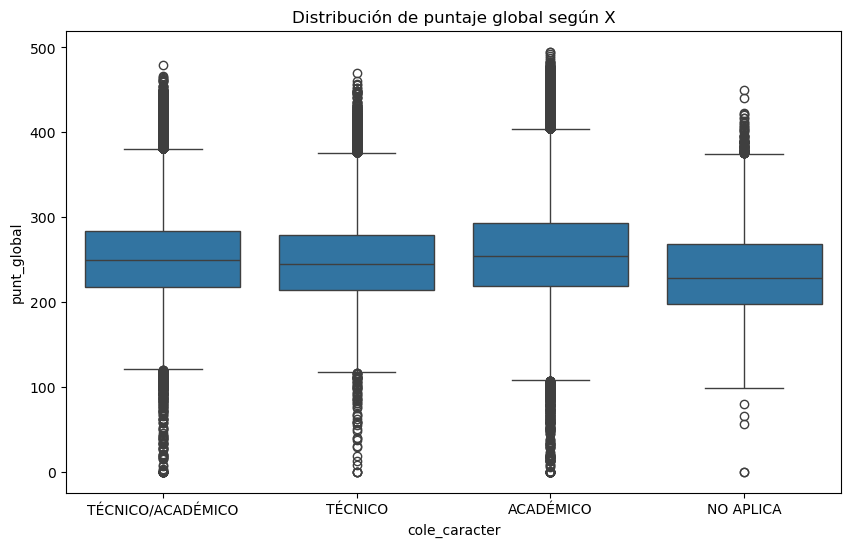

In [50]:
plt.figure(figsize=(10,6))
sb.boxplot(x='cole_caracter', y='punt_global', data=saber11_df)
plt.title('Distribución de puntaje global según X')
plt.show()

In [51]:
for col in cat_cols:
    freqs = saber11_df[col].value_counts(normalize=True)
    rare = freqs[freqs < 0.01]
    if not rare.empty:
        print(f"\n'{col}' tiene categorías poco representadas (<1%):")
        print(rare)


'cole_calendario' tiene categorías poco representadas (<1%):
cole_calendario
OTRO    0.00491
Name: proportion, dtype: float64

'cole_caracter' tiene categorías poco representadas (<1%):
cole_caracter
NO APLICA    0.007694
Name: proportion, dtype: float64

'cole_depto_ubicacion' tiene categorías poco representadas (<1%):
cole_depto_ubicacion
CAQUETA       0.007432
CHOCO         0.007408
PUTUMAYO      0.007394
ARAUCA        0.005359
GUAVIARE      0.001678
AMAZONAS      0.001403
SAN ANDRES    0.001157
VICHADA       0.000871
VAUPES        0.000621
GUAINIA       0.000448
Name: proportion, dtype: float64

'cole_genero' tiene categorías poco representadas (<1%):
cole_genero
MASCULINO    0.009168
Name: proportion, dtype: float64

'cole_mcpio_ubicacion' tiene categorías poco representadas (<1%):
cole_mcpio_ubicacion
BELLO                          0.009809
VALLEDUPAR                     0.009808
MONTERIA                       0.009466
PASTO                          0.009362
MANIZALES           

In [29]:
# Quitar columnas que incluyen códigos de establecimiento o geografía, que son redundantes

cols_a_eliminar = [
    'cole_mcpio_ubicacion', 'estu_mcpio_presentacion', 'estu_mcpio_reside'
]

saber11_df = saber11_df.drop(columns=[c for c in cols_a_eliminar if c in saber11_df.columns])

In [5]:
from sklearn.feature_selection import f_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Convertir categóricas a numéricas temporalmente
df_enc = saber11_df.copy()
for col in cat_cols:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col].astype(str))

X = df_enc.drop(columns=targets)
y = saber11_df['punt_lectura_critica']

mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi.head(10)

NameError: name 'cat_cols' is not defined

In [7]:
tabla = pd.crosstab(saber11_df['periodo_presentacion'], saber11_df['cole_calendario'])
print(tabla)

cole_calendario             A      B  OTRO
periodo_presentacion                      
1                       20720  97350  2946
2                     2096714   4004  9413
4                      936688   1497  3219


In [8]:
from scipy.stats import chi2_contingency

# Tabla de contingencia
tabla = pd.crosstab(saber11_df['periodo_presentacion'], saber11_df['cole_calendario'])

# Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla)

# Cramer’s V
n = tabla.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(tabla.shape) - 1)))

print(f"Chi-cuadrado: {chi2:.3f}")
print(f"p-value: {p:.4f}")
print(f"Cramer's V: {cramers_v:.3f}")

Chi-cuadrado: 2404768.599
p-value: 0.0000
Cramer's V: 0.616
